# Fast Neural Style Transfer

In [1]:
from collections import namedtuple
import time 

import matplotlib.pyplot as plt
import numpy as np
import torch
# For getting VGG model
import torchvision.models.vgg as vgg
import torch.utils.model_zoo as model_zoo
# Image transformation pipeline
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.optim import Adam
from torch.autograd import Variable
from PIL import Image
from tqdm import tqdm_notebook

from transformer_net import TransformerNet
from utils import gram_matrix

%matplotlib inline

In [2]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [3]:
SEED = 1080
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    kwargs = {'num_workers': 4, 'pin_memory': True}
else:
    torch.set_default_tensor_type('torch.FloatTensor')
    kwargs = {}

In [4]:
IMAGE_SIZE = 256
BATCH_SIZE = 4
DATASET = "coco/"
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225])
transform = transforms.Compose([transforms.Scale(IMAGE_SIZE),
                                transforms.CenterCrop(IMAGE_SIZE),
                                transforms.ToTensor(),
                                normalize])
# http://pytorch.org/docs/master/torchvision/datasets.html#imagefolder
train_dataset = datasets.ImageFolder(DATASET, transform)
# http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, **kwargs)

In [5]:
LossOutput = namedtuple("LossOutput", ["relu1_2", "relu2_2", "relu3_3", "relu4_3"])

# https://discuss.pytorch.org/t/how-to-extract-features-of-an-image-from-a-trained-model/119/3
class LossNetwork(torch.nn.Module):
    def __init__(self, vgg_model):
        super(LossNetwork, self).__init__()
        self.vgg_layers = vgg_model.features
        self.layer_name_mapping = {
            '3': "relu1_2",
            '8': "relu2_2",
            '15': "relu3_3",
            '22': "relu4_3"
        }
    
    def forward(self, x):
        output = {}
        for name, module in self.vgg_layers._modules.items():
            x = module(x)
            if name in self.layer_name_mapping:
                output[self.layer_name_mapping[name]] = x
        return LossOutput(**output)

In [6]:
vgg_model = vgg.vgg16(pretrained=True)
if torch.cuda.is_available():
    vgg_model.cuda()
loss_network = LossNetwork(vgg_model)
del vgg_model

In [7]:
def recover_image(img):
    return (
        (img * 
       np.array([0.229, 0.224, 0.225]).reshape((1, 3, 1, 1)) + 
       np.array([0.485, 0.456, 0.406]).reshape((1, 3, 1, 1))).transpose(0, 2, 3, 1) * 255.
    ).clip(0, 255).astype(np.uint8)

In [8]:
STYLE_IMAGE = "style_images/starry-night-cropped.jpg"
style_img = Image.open(STYLE_IMAGE).convert('RGB')
style_img_tensor = transforms.Compose([transforms.ToTensor(),
                            normalize])(style_img).unsqueeze(0)
# assert np.sum(style_img - recover_image(style_img_tensor.numpy())[0].astype(np.uint8)) < 3 * style_img_tensor.size()[2] * style_img_tensor.size()[3]
if torch.cuda.is_available():
    style_img_tensor = style_img_tensor.cuda()

In [9]:
style_img.size

(769, 640)

In [10]:
style_img_tensor.size()

torch.Size([1, 3, 640, 769])

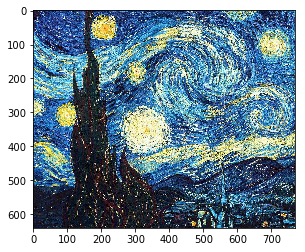

In [11]:
plt.imshow(recover_image(style_img_tensor.cpu().numpy())[0])

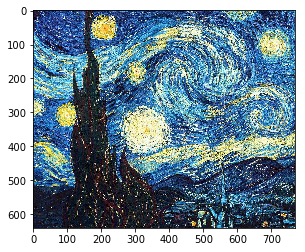

In [12]:
plt.imshow(recover_image(style_img_tensor.cpu().numpy())[0])

In [13]:
# http://pytorch.org/docs/master/notes/autograd.html#volatile
style_loss_features = loss_network(Variable(style_img_tensor, volatile=True))
gram_style = [Variable(gram_matrix(y).data, requires_grad=False) for y in style_loss_features]

In [14]:
style_loss_features._fields

('relu1_2', 'relu2_2', 'relu3_3', 'relu4_3')

In [15]:
np.mean(gram_style[3].data.cpu().numpy())

0.024460834

In [16]:
np.mean(style_loss_features[0].data.cpu().numpy())

1.2605699

In [17]:
gram_style[0].numel()

4096

In [18]:
def save_debug_image(tensor_orig, tensor_transformed, filename):
    assert tensor_orig.size() == tensor_transformed.size()
    result = Image.fromarray(recover_image(tensor_transformed.cpu().numpy())[0])
    orig = Image.fromarray(recover_image(tensor_orig.cpu().numpy())[0])
    new_im = Image.new('RGB', (result.size[0] * 2 + 5, result.size[1]))
    new_im.paste(orig, (0,0))
    new_im.paste(result, (result.size[0] + 5,0))
    new_im.save(filename)

In [19]:
%mkdir -p debug

In [22]:
transformer = TransformerNet()
mse_loss = torch.nn.MSELoss()
l1_loss = torch.nn.L1Loss()
if torch.cuda.is_available():
    transformer.cuda()

In [23]:
CONTENT_WEIGHT = 1
STYLE_WEIGHT = 10
LOG_INTERVAL = 200
REGULARIZATION = 1e-8

LR = 1e-3
optimizer = Adam(transformer.parameters(), LR)

for epoch in range(2):
    transformer.train()
    agg_content_loss = 0.
    agg_style_loss = 0.
    agg_reg_loss = 0.
    count = 0
    for batch_id, (x, _) in tqdm_notebook(enumerate(train_loader), total=len(train_loader)):
        n_batch = len(x)
        count += n_batch
        optimizer.zero_grad()
        x = Variable(x)
        if torch.cuda.is_available():
            x = x.cuda()

        y = transformer(x)
        xc = Variable(x.data, volatile=True)

        features_y = loss_network(y)
        features_xc = loss_network(xc)

        f_xc_c = Variable(features_xc[1].data, requires_grad=False)

        content_loss = CONTENT_WEIGHT * mse_loss(features_y[1], f_xc_c)

        reg_loss = REGULARIZATION * (
            torch.sum(torch.abs(y[:, :, :, :-1] - y[:, :, :, 1:])) + 
            torch.sum(torch.abs(y[:, :, :-1, :] - y[:, :, 1:, :])))

        style_loss = 0.
        for m in range(len(features_y)):
            gram_s = gram_style[m]
            gram_y = gram_matrix(features_y[m])
            style_loss += STYLE_WEIGHT * mse_loss(gram_y, gram_s.expand_as(gram_y))

        total_loss = content_loss + style_loss + reg_loss
        total_loss.backward()
        optimizer.step()

        agg_content_loss += content_loss.data[0]
        agg_style_loss += style_loss.data[0]
        agg_reg_loss += reg_loss.data[0]

        if (batch_id + 1) % LOG_INTERVAL == 0:
            mesg = "{} [{}/{}] content: {:.6f}  style: {:.6f}  reg: {:.6f}  total: {:.6f}".format(
                        time.ctime(), count, len(train_dataset),
                        agg_content_loss / LOG_INTERVAL,
                        agg_style_loss / LOG_INTERVAL,
                        agg_reg_loss / LOG_INTERVAL,
                        (agg_content_loss + agg_style_loss + agg_reg_loss) / LOG_INTERVAL
                    )
            print(mesg)
            agg_content_loss = 0
            agg_style_loss = 0
            agg_reg_loss = 0
            save_debug_image(x.data, y.data, "debug/{}_{}.png".format(epoch, count))


Fri Jul 28 09:41:12 2017 [800/82783] content: 19.798733  style: 93.065599  reg: 0.008783  total: 112.873115
Fri Jul 28 09:42:26 2017 [1600/82783] content: 21.010950  style: 9.408078  reg: 0.010324  total: 30.429351
Fri Jul 28 09:43:39 2017 [2400/82783] content: 20.696449  style: 6.272672  reg: 0.010758  total: 26.979879
Fri Jul 28 09:44:53 2017 [3200/82783] content: 20.180266  style: 5.201670  reg: 0.011066  total: 25.393003
Fri Jul 28 09:46:07 2017 [4000/82783] content: 19.852012  style: 4.467073  reg: 0.011234  total: 24.330319
Fri Jul 28 09:47:21 2017 [4800/82783] content: 19.599797  style: 4.102111  reg: 0.011346  total: 23.713254
Fri Jul 28 09:48:35 2017 [5600/82783] content: 19.286167  style: 3.859865  reg: 0.011435  total: 23.157467
Fri Jul 28 09:49:49 2017 [6400/82783] content: 19.128272  style: 3.715249  reg: 0.011480  total: 22.855001
Fri Jul 28 09:51:05 2017 [7200/82783] content: 18.826914  style: 3.498614  reg: 0.011515  total: 22.337043
Fri Jul 28 09:52:20 2017 [8000/8278

Fri Jul 28 11:16:30 2017 [61600/82783] content: 15.337522  style: 2.407927  reg: 0.012465  total: 17.757914
Fri Jul 28 11:17:43 2017 [62400/82783] content: 15.276870  style: 2.357427  reg: 0.012466  total: 17.646764
Fri Jul 28 11:18:57 2017 [63200/82783] content: 15.215870  style: 2.405652  reg: 0.012487  total: 17.634008
Fri Jul 28 11:20:10 2017 [64000/82783] content: 15.220150  style: 2.414498  reg: 0.012478  total: 17.647125
Fri Jul 28 11:21:24 2017 [64800/82783] content: 15.272881  style: 2.516956  reg: 0.012491  total: 17.802328
Fri Jul 28 11:22:38 2017 [65600/82783] content: 15.152701  style: 2.359340  reg: 0.012490  total: 17.524532
Fri Jul 28 11:23:52 2017 [66400/82783] content: 15.160693  style: 2.321136  reg: 0.012498  total: 17.494327
Fri Jul 28 11:25:06 2017 [67200/82783] content: 15.168832  style: 2.347172  reg: 0.012501  total: 17.528505
Fri Jul 28 11:26:20 2017 [68000/82783] content: 15.133170  style: 2.343639  reg: 0.012515  total: 17.489325
Fri Jul 28 11:27:34 2017 [68

Fri Jul 28 11:50:28 2017 [800/82783] content: 15.155551  style: 2.286231  reg: 0.012581  total: 17.454363
Fri Jul 28 11:51:44 2017 [1600/82783] content: 15.029982  style: 2.263484  reg: 0.012592  total: 17.306058
Fri Jul 28 11:52:59 2017 [2400/82783] content: 15.021738  style: 2.230414  reg: 0.012595  total: 17.264746
Fri Jul 28 11:54:16 2017 [3200/82783] content: 14.950206  style: 2.227546  reg: 0.012609  total: 17.190360
Fri Jul 28 11:55:32 2017 [4000/82783] content: 14.970389  style: 2.267567  reg: 0.012613  total: 17.250569
Fri Jul 28 11:56:49 2017 [4800/82783] content: 14.999507  style: 2.415837  reg: 0.012608  total: 17.427952
Fri Jul 28 11:58:05 2017 [5600/82783] content: 15.025643  style: 2.354585  reg: 0.012616  total: 17.392844
Fri Jul 28 11:59:22 2017 [6400/82783] content: 14.903867  style: 2.282082  reg: 0.012618  total: 17.198567
Fri Jul 28 12:00:38 2017 [7200/82783] content: 14.964872  style: 2.239208  reg: 0.012633  total: 17.216713
Fri Jul 28 12:01:53 2017 [8000/82783] 

Fri Jul 28 13:26:12 2017 [61600/82783] content: 14.590708  style: 2.110029  reg: 0.012997  total: 16.713733
Fri Jul 28 13:27:28 2017 [62400/82783] content: 14.536245  style: 2.172852  reg: 0.012980  total: 16.722077
Fri Jul 28 13:28:43 2017 [63200/82783] content: 14.590662  style: 2.146034  reg: 0.012999  total: 16.749695
Fri Jul 28 13:29:59 2017 [64000/82783] content: 14.555983  style: 2.154353  reg: 0.012996  total: 16.723332
Fri Jul 28 13:31:15 2017 [64800/82783] content: 14.619502  style: 2.159582  reg: 0.013016  total: 16.792100
Fri Jul 28 13:32:31 2017 [65600/82783] content: 14.536343  style: 2.172036  reg: 0.013013  total: 16.721392
Fri Jul 28 13:33:46 2017 [66400/82783] content: 14.537151  style: 2.097585  reg: 0.013031  total: 16.647767
Fri Jul 28 13:35:02 2017 [67200/82783] content: 14.521324  style: 2.118253  reg: 0.013053  total: 16.652630
Fri Jul 28 13:36:18 2017 [68000/82783] content: 14.550716  style: 2.143466  reg: 0.013040  total: 16.707223
Fri Jul 28 13:37:33 2017 [68

In [24]:
import glob
fnames = glob.glob(DATASET + r"/*/*")
len(fnames)

82783

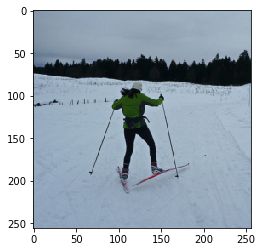

In [25]:
img = Image.open(fnames[40]).convert('RGB')
transform = transforms.Compose([transforms.Scale(IMAGE_SIZE),
                                transforms.CenterCrop(IMAGE_SIZE),
                                transforms.ToTensor(),
                                normalize])
img_tensor = transform(img).unsqueeze(0)
if torch.cuda.is_available():
    img_tensor = img_tensor.cuda()

img_output = transformer(Variable(img_tensor, volatile=True))
plt.imshow(recover_image(img_tensor.cpu().numpy())[0])

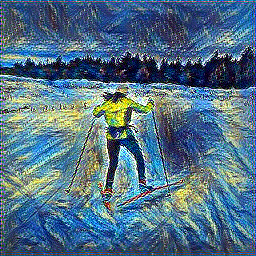

In [26]:
Image.fromarray(recover_image(img_output.data.cpu().numpy())[0])

In [27]:
save_model_path = "model_starry.pth"
torch.save(transformer.state_dict(), save_model_path)

In [28]:
transformer.load_state_dict(torch.load(save_model_path))

torch.Size([1, 3, 1080, 1080])


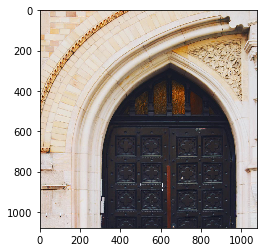

In [29]:
img = Image.open("content_images/amber.jpg").convert('RGB')
transform = transforms.Compose([transforms.ToTensor(),
                                normalize])
img_tensor = transform(img).unsqueeze(0)
print(img_tensor.size())
if torch.cuda.is_available():
    img_tensor = img_tensor.cuda()

img_output = transformer(Variable(img_tensor, volatile=True))
plt.imshow(recover_image(img_tensor.cpu().numpy())[0])

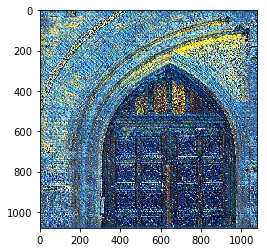

In [30]:
plt.imshow(recover_image(img_output.data.cpu().numpy())[0])

In [31]:
output_img = Image.fromarray(recover_image(img_output.data.cpu().numpy())[0])
output_img.save("amber.png")